using the multi-class Perceptron instead of the multi-class Softmax cost

In [30]:
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True   
import matplotlib.pyplot as plt
# import statment for gradient calculator
from autograd import grad
from autograd import numpy as np
from autograd import value_and_grad
from autograd import hessian
from mlxtend.data import loadlocal_mnist

In [59]:
from autograd.misc.flatten import flatten_func
#numtrain is P
def batch_gradient_descent(g,alpha_choice,max_epochs,w, num_train, batch_size):
    g_flat, unflatten, w = flatten_func(g, w)
    gradient = value_and_grad(g_flat)
#     gradient = value_and_grad(g)
    
    weight_history = [unflatten(w)]  #same as weight_history = [init_point]
#     weight_history = []
    
    cost_history = [g_flat(w,x,y,np.arange(num_train))]
#     cost_history = []

    # how many mini-batches equal the entire dataset?
    num_batches = int(np.ceil(np.divide(num_train, batch_size)))

#     alpha = 0
    for k in range(max_epochs):
        # check if diminishing steplength rule used
#         if alpha_choice == 'diminishing':
#             alpha = 1/float(k)
#         else:
#             alpha = alpha_choice
        train_cost = 0
        for b in range(num_batches):
            #get indices for current mini batch
            batch_inds = np.arange(b*batch_size, min((b+1)*batch_size, num_train))
            
            cost_eval,grad_eval = gradient(w,x,y,batch_inds)
            grad_eval.shape = np.shape(w)
            
            #take step
            w = w-alpha*grad_eval
            
            train_cost = g_flat(w,x,y,np.arange(num_train))
            weight_history.append(unflatten(w))
            cost_history.append(train_cost)
            
#             grad_eval = grad_eval

#             # take step
#             w = w - alpha*grad_eval
            
    # collect final weights
#         weight_history.append(w) 
#         cost_history.append(g(w))  
    return weight_history,cost_history

In [45]:
# lam = 10**-5
# def multiclass_perceptron(w):
#     all_evals = model(x,w)
#     a = np.max(all_evals, axis = 0)
    
#     b = all_evals[y.astype(int).flatten(),np.arange(np.size(y))]
#     cost = np.sum(a-b)
    
#     cost = cost + lam*np.linalg.norm(w[1:,:],'fro')**2
    
#     return cost/float(np.size(y))

In [46]:
# # load in data
# from sklearn.datasets import fetch_mldata
# mnist = fetch_mldata('MNIST original')

# # strip off input / output pairs
# x = mnist.data.T
# y = mnist.target[np.newaxis,:]

In [47]:
from sklearn.datasets import fetch_mldata
try:
    mnist = fetch_mldata('MNIST original')
except Exception as ex:        
    from six.moves import urllib
    from scipy.io import loadmat
    import os

    mnist_path = os.path.join(".", "datasets", "mnist-original.mat")

    # download dataset from github.
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, "wb") as f:
        content = response.read()
        f.write(content)

    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }
    print("Done!")

Done!


In [48]:
# strip off input / output pairs
x = mnist['data'].T
y = mnist['target'][np.newaxis,:]

In [49]:
print("input shape = " , x.shape)
print("output shape = ", y.shape)

input shape =  (784, 70000)
output shape =  (1, 70000)


In [50]:
# sample indices
num_sample = 50000
inds = np.random.permutation(y.shape[1])[:num_sample]
x_sample = x[:,inds]
y_sample = y[:,inds]

<IPython.core.display.Javascript object>


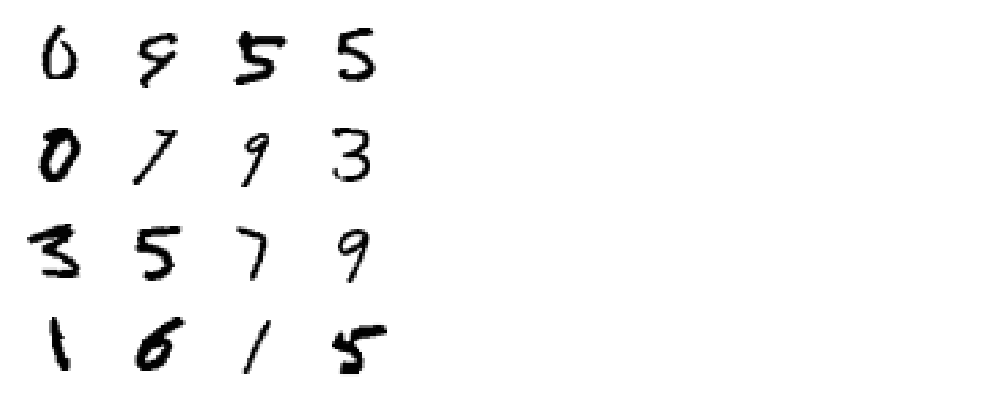

In [56]:
from matplotlib import gridspec
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10,4))
gs=GridSpec(4,10)

for i in range(0, 16):
    fig.add_subplot(gs[i%4 + int(i/4)*10])
    plt.imshow(np.max(x_sample[:,i]) - np.reshape(x_sample[:,i],(28,28)), cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.axis('off') 
plt.show()

In [52]:
# compute C linear combinations of input point, one per classifier
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

# multiclass perceptron
def multiclass_perceptron(w,x,y,iter):
    # get subset of points
    x_p = x[:,iter]
    y_p = y[:,iter]

    # pre-compute predictions on all points
    all_evals = model(x_p,w)

    # compute maximum across data points
    a =  np.max(all_evals,axis = 0)        

    # compute cost in compact form using numpy broadcasting
    b = all_evals[y_p.astype(int).flatten(),np.arange(np.size(y_p))]
    cost = np.sum(a - b)

    # return average
    return cost/float(np.size(y_p))

In [53]:
# create a matrix of weights to evaluate mult-class cost
N = x_sample.shape[0]
C = len(np.unique(y_sample))
w = 0.1*np.random.randn(N+1,C)
print (w.shape)

(785, 10)


In [54]:
pts_to_evaluate = (1,10,22)
multiclass_perceptron(w,x_sample,y_sample,pts_to_evaluate)

242.5483802444136

In [ ]:
alpha_choice = 10**(-1)
max_epochs = 10
num_train = 50000
batch_size = 200
wh1, ch1 = batch_gradient_descent(multiclass_perceptron,alpha_choice,max_epochs,w, num_train, batch_size)

In [ ]:
def compare_runs(full_cost_hist,stoch_cost_hist,minibatch_cost_hist):
    # create figure and color pattern
    fig = plt.figure(figsize = (10,3))
    colors = ['k','r','b']

    ### plot all with respect to smallest mini-batch size ###
    ax = plt.subplot(1,2,1)

    # num steps per run
    stoch_count = len(stoch_cost_hist)
    mini_count = len(minibatch_cost_hist)
    full_count = len(full_cost_hist)

    # plot stochastic
#     ax.plot(stoch_cost_hist, label='batch size = 1',c = colors[0],linewidth=1.5)
    ax.plot(stoch_cost_hist, 'k-', label='batch size = 1',linewidth=1.5)

    # plot mini and full batch with respect to stochastic
    range_mini = np.linspace(0,stoch_count,mini_count)
    ax.plot(range_mini,minibatch_cost_hist, label='batch size = 10',c = colors[1],linewidth=1)
    ax.scatter(range_mini,minibatch_cost_hist,c=colors[1],s=90,edgecolor = 'w',linewidth=0.5)

    range_full = np.linspace(0,stoch_count,full_count)
    ax.plot(range_full,full_cost_hist, label='full batch',c = colors[2],linewidth=1)
    ax.scatter(range_full,full_cost_hist,c=colors[2],s=90,edgecolor = 'w',linewidth=0.5)

    # label panel
    ax.set_title('progress with respect to batch size = 1 method')
    ax.set_xlabel('single summand')
    ax.legend(loc="upper right")

    ### plot with respect to epoch number ###
    ax = plt.subplot(1,2,2)

    # plot stochastic batch
    inds_stoch = np.linspace(0,stoch_count,full_count)
    inds_stoch = [int(v) for v in inds_stoch]
    inds_stoch[-1]-=1
    plot_stoch = [stoch_cost_hist[v] for v in inds_stoch]
    ax.plot(plot_stoch, label='batch size = 1',c = colors[0],linewidth=1.5)
    ax.scatter(np.arange(full_count),plot_stoch,c=colors[0],s=90,edgecolor = 'w',linewidth=0.5)
    
    # plot mini and full batch with respect to stochastic
    inds_mini = np.linspace(0,mini_count,full_count)
    inds_mini = [int(v) for v in inds_mini]
    inds_mini[-1]-=1
    plot_mini = [minibatch_cost_hist[v] for v in inds_mini]
    ax.plot(plot_mini, label='batch size = 10',c = colors[1],linewidth=1)
    ax.scatter(np.arange(full_count),plot_mini,c=colors[1],s=90,edgecolor = 'w',linewidth=0.5)

    # plot full cost
    ax.plot(full_cost_hist, label='full batch',c = colors[2],linewidth=1)
    ax.scatter(np.arange(full_count),full_cost_hist,c=colors[2],s=90,edgecolor = 'w',linewidth=0.5)
    ax.set_title('progress with respect to full batch method')
    ax.set_xticks(np.arange(full_count))
    ax.set_xlabel('full epochs')
    ax.legend(loc="upper right")

    # plot all with respect to epoch number
    plt.show()
    